## 3. Modelos Preditivos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from pandas_profiling import ProfileReport

/home/valeriaps/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
class Experiment():
    def __init__(self):

        self.X_train, self.X_test = [], []
        self.y_train, self.y_test = [], []
        self.train_index, self.test_index = [], []
        self.train_pred, self.test_pred = [], []
        self.clf = None
        self.accuracy_train, self.accuracy_test = [], []
        self.precision_train, self.precision_test = [], []
        self.recall_train, self.recall_test = [], []
        self.f1_train, self.f1_test = [], []
        
        self.mean_accuracy_train = 0
        self.mean_accuracy_test = 0
        self.mean_precision_train = 0
        self.mean_precision_test = 0
        self.mean_recall_train = 0
        self.mean_recall_test = 0
        self.mean_f1_train = 0
        self.mean_f1_test = 0
        
        self.fpr_fold = []
        self.tpr_fold = []
        self.mean_fpr = 0
        self.mean_tpr = 0
        self.test_pred_proba=0

    def run_naive_bayes(self):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = GaussianNB()
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
    
    def run_decision_tree(self, depth):
        mean_fpr = np.linspace(0,1,100)
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = DecisionTreeClassifier(max_depth=depth)
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
                      
    def get_folds(self):
        kfold = KFold(N_FOLDS, True, 1)
        return kfold.split(X)

    def slice_fold(self):
        global X
        global y
        self.X_train = X.iloc[self.train_index]
        self.y_train = y[self.train_index]
        
        self.X_test = X.iloc[self.test_index]
        self.y_test = y[self.test_index]
         
    def get_predictions(self, clf):
        self.train_pred = clf.predict(self.X_train)
        self.test_pred = clf.predict(self.X_test)
        
    def get_metrics_per_fold(self):
        self.accuracy_train.append(accuracy_score(self.y_train, self.train_pred))
        self.accuracy_test.append(accuracy_score(self.y_test, self.test_pred))
        
        self.precision_train.append(precision_score(self.y_train, self.train_pred))
        self.precision_test.append(precision_score(self.y_test, self.test_pred))
        
        self.recall_train.append(recall_score(self.y_train, self.train_pred))
        self.recall_test.append(recall_score(self.y_test, self.test_pred))
        
        self.f1_train.append(f1_score(self.y_train, self.train_pred))
        self.f1_test.append(f1_score(self.y_test, self.test_pred))
            
    def get_means(self):
        self.mean_accuracy_train = np.mean(self.accuracy_train)
        self.mean_accuracy_test = np.mean(self.accuracy_test)
        self.mean_precision_train = np.mean(self.precision_train)
        self.mean_precision_test = np.mean(self.precision_test)
        self.mean_recall_train = np.mean(self.recall_train)
        self.mean_recall_test = np.mean(self.recall_test)
        self.mean_f1_train = np.mean(self.f1_train)
        self.mean_f1_test = np.mean(self.f1_test)
#         self.mean_fpr = np.mean(self.fpr_fold)
#         self.mean_tpr = np.mean(self.tpr_fold)
        
    def print_results(self):
        print("Train")
        print("  Accuracy: {:.3f}".format(self.mean_accuracy_train))
        print("  Precision: {:.3f}".format(self.mean_precision_train))
        print("  Recall: {:.3f}".format(self.mean_recall_train))
        print("  f1: {:.3f}".format(self.mean_f1_train))

        print()
        
        print("Test")
        print("  Accuracy: {:.3f}".format(self.mean_accuracy_test))
        print("  Precision: {:.3f}".format(self.mean_precision_test))
        print("  Recall: {:.3f}".format(self.mean_recall_test))
        print("  f1: {:.3f}".format(self.mean_f1_test))

def save_results(objeto, metrics = {}):
    """ 
    Função auxiliar que salva resultados de muitos experimentos
    """    
    metrics['accuracy_train'].append(objeto.mean_accuracy_train)
    metrics['accuracy_test'].append(objeto.mean_accuracy_test)
                            
    metrics['precision_train'].append(objeto.mean_precision_train)
    metrics['precision_test'].append(objeto.mean_precision_test)
    
    metrics['recall_train'].append(objeto.mean_recall_train)
    metrics['recall_test'].append(objeto.mean_recall_test)
    
    metrics['f1_train'].append(objeto.mean_f1_train)
    metrics['f1_test'].append(objeto.mean_f1_test)
  
    return metrics

def plot_results(x, metrics, baseline, name='Decision Tree', parameter='Altura'):
    
    plt.subplot()
    plt.title(name + ' - ACCURACY')
    plt.xlabel(parameter)
    plt.ylabel('Accuracy')
    plt.axhline(baseline.mean_accuracy_test, linestyle='--', color='grey')
    plt.plot(x, metrics['accuracy_train'], label = 'treino')
    plt.plot(x, metrics['accuracy_test'], label = 'teste')
    plt.legend(loc='best')
    plt.show()

    plt.subplot()
    plt.title(name + ' - F1 SCORE')
    plt.xlabel(parameter)
    plt.ylabel('f1 score')
    plt.axhline(baseline.mean_f1_test, linestyle='--', color='grey')
    plt.plot(x, metrics['f1_train'], label = 'treino')
    plt.plot(x, metrics['f1_test'], label = 'teste')
    plt.legend(loc='best')
    plt.show()

In [3]:
TARGET = "left_Company"
N_FOLDS = 5

In [4]:
X = pd.read_hdf('data/data.h5', key='X_clean')
y = X[TARGET]
X = X.drop(columns=[TARGET])

## Encoding

In [5]:
encoder = OneHotEncoder()
X = pd.DataFrame(encoder.fit_transform(X).toarray())

X = encoder.transform()

In [8]:
y = np.array(y)

In [9]:
y

array([0, 0, 0, ..., 1, 1, 1])

## Naive Bayes

Foi utlizada a implementação Gaussian Naive Bayes.

In [18]:
baseline = Experiment()
baseline.run_naive_bayes()
baseline.print_results()

Train
  Accuracy: 0.838
  Precision: 0.597
  Recall: 0.983
  f1: 0.743

Test
  Accuracy: 0.835
  Precision: 0.593
  Recall: 0.977
  f1: 0.738


## Decision Tree

In [13]:
metrics_dt={
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

In [14]:
espaco_de_busca_dt = range(1, 30+1) 

In [21]:
for i in tqdm(espaco_de_busca_dt):
    decision_tree = Experiment()
    decision_tree.run_decision_tree(i)
    metrics = save_results(decision_tree, metrics_dt)
decision_tree.print_results()

/home/valeriaps/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.



Train
  Accuracy: 0.997
  Precision: 0.987
  Recall: 0.999
  f1: 0.993

Test
  Accuracy: 0.978
  Precision: 0.948
  Recall: 0.960
  f1: 0.954


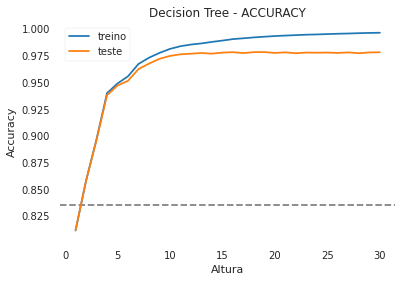

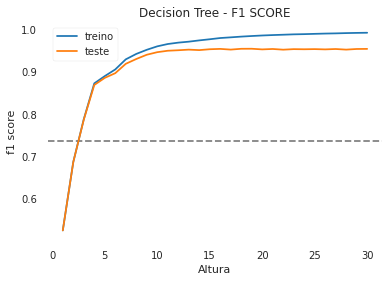

In [19]:
plot_results(espaco_de_busca_dt, metrics_dt, baseline, name='Decision Tree', parameter='Altura')

In [20]:
print('Acurácia teste')
for i in espaco_de_busca_dt:    
    print(i, ':{:.3f} '.format(metrics['accuracy_test'][i-1]))

Acurácia teste
1 :0.812 
2 :0.858 
3 :0.896 
4 :0.938 
5 :0.947 
6 :0.952 
7 :0.963 
8 :0.968 
9 :0.972 
10 :0.975 
11 :0.976 
12 :0.977 
13 :0.978 
14 :0.977 
15 :0.978 
16 :0.978 
17 :0.978 
18 :0.978 
19 :0.979 
20 :0.978 
21 :0.978 
22 :0.977 
23 :0.978 
24 :0.978 
25 :0.978 
26 :0.978 
27 :0.978 
28 :0.977 
29 :0.978 
30 :0.978 


**Análise do resultado**  
* A Decision Tree tende a overfittar caso não seja podada adequandamente. POdemos ver que aproximadamente a partir da altura 10 ocorre o overfitting.
* A acurácia de teste mostra que a partir da altura 9, o ganho é desconsiderável sendo preferível um modelo mais simples